# <center> Description des pipelines - Problématique 2 </center>

In [46]:
# Librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing_pb2 import *
from matrice_similarity import *
from load_data import *

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 100)

## Save Model

### 1) Load data

In [2]:
# Import data
df = load_data('../Data/df_metric_learning.csv')

### 2) Preprocessing 

In [3]:
unique_brand = open('../Data/brand.txt').read().split(',')
stop_words = load_txt("../Data/stop_words.txt")
tag_dir = '/Users/valentinphetchanpheng/Downloads/treetagger'

In [4]:
df = preprocessing_similarity(df, 'productseller_name', 'brand_seller', 'Description', 'brand', 'model', unique_brand, stop_words, tag_dir, dico1, dico2, dico_regex)


In [5]:
col = ['id_page',
       'label',
       'productseller_name',
       'brand',
       'Description',
       'Volume_unit',
       'Mesure_unit',
       'Poids_unit',
       'AmpereHeure',
       'NewtonMetre',
       'Watt',
       'Volt',
       'Rpm',
       'Joules',
       'Metre2',
       'Couleur',
       'product_price',
       'model',
       'Description_clean']

df = df[col]

### 3) Embedding TF IDF / NMF

In [6]:
# Embedding
tfidf = TfidfVectorizer(lowercase=False)
tf_idf = csr_matrix(tfidf.fit_transform(df['Description_clean'].values))
nmf = NMF(n_components=250, alpha=.1, l1_ratio=.5).fit_transform(tf_idf)
topics = ["topic_"+str(i) for i in range(250)]
df_topics = pd.DataFrame(nmf, columns=topics).set_index(df.index)

df = pd.concat((df, df_topics), axis=1)

### 4) Matrice des distances

In [34]:
list_attributes_standard = ["product_price", "Couleur", "brand", "model"]
list_units = ["Volt", "Watt", "AmpereHeure", "NewtonMetre", "Poids_unit", "Mesure_unit", "Volume_unit", 'Rpm', 'Joules', 'Metre2']

In [35]:
# Get the matrix of similarity given the category
X, y, pair_id_page, list_features = get_matrix_similarity(df, 100, 0.6, list_attributes_standard, list_units, topics)


### 5) Classification : mode training

In [36]:
# Train set & test set
X_train, X_test, y_train, y_test, id_page_train, id_page_test = train_test_split(X, y, pair_id_page, test_size=0.2, stratify=y, random_state=2)


In [37]:
# Classifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=2, n_jobs=-1)
clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

## Prediction

In [38]:
prediction = clf.predict(X_test)
prediction_proba = clf.predict_proba(X_test)

## Metrics

In [39]:
# Evaluation
print("accuracy : ", round(accuracy_score(prediction, y_test),4), "\n")
print("recall : ", round(recall_score(prediction, y_test),4))
print("precision : ", round(precision_score(prediction, y_test),4))
print("f1_score : ", round(f1_score(prediction, y_test),4))

accuracy :  0.9858 

recall :  0.9211
precision :  0.8642
f1_score :  0.8917


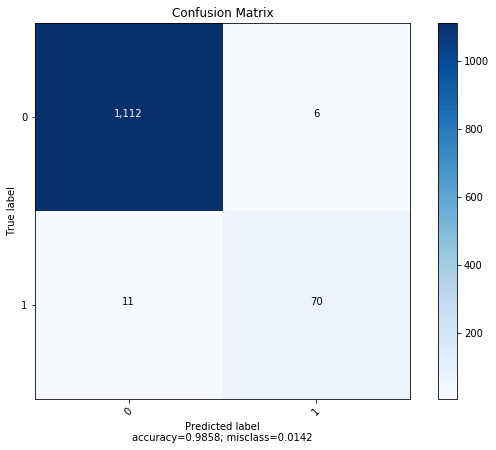

In [40]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, prediction_proba[:,1])
roc_auc = auc(fpr, tpr)

#GRAPH DATA
plt.figure(figsize=(8,6))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.plot(fpr, tpr, color='green', lw=1, label='ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [42]:
result = pd.DataFrame()
result['test'] = y_test
result['predict'] = prediction
result['predict_proba_0'] = prediction_proba[:,0]
result['predict_proba_1'] = prediction_proba[:,1]
result['paire_id_page'] = id_page_test
print('Resultat :')
result[result['predict']==1].head(10)

Resultat :


test  predict  predict_proba_0  predict_proba_1  \
11      1        1             0.18             0.82   
18      1        1             0.00             1.00   
75      1        1             0.04             0.96   
77      1        1             0.00             1.00   
91      1        1             0.05             0.95   
99      1        1             0.11             0.89   
123     1        1             0.02             0.98   
166     1        1             0.03             0.97   
187     1        1             0.00             1.00   
225     1        1             0.00             1.00   

                                                                             paire_id_page  
11   /prix/4526035/black-decker-gkc1820l20.html_/prix/4526035/black-decker-gkc1820l20.html  
18                 /prix/5594569/ryobi-rcs36b35hi.html_/prix/5594569/ryobi-rcs36b35hi.html  
75   /prix/4526035/black-decker-gkc1820l20.html_/prix/4526035/black-decker-gkc1820l20.html  
77                                           /type/88381807968.html_/type/88381807968.html  
91                                           /type/88381807968.html_/type/88381807968.html  
99                 /prix/4670256/dolmar-es-39-tlc.html_/prix/4670256/dolmar-es-39-tlc.html  
123      /prix/3049273/mcculloch-cs410-elite.html_/prix/3049273/mcculloch-cs410-elite.html  
166                    /prix/4549142/ryobi-rcs-2340.html_/prix/4549142/ryobi-rcs-2340.html  
187      /prix/3049273/mcculloch-cs410-elite.html_/prix/3049273/mcculloch-cs410-elite.html  
225            /prix/4553834/ryobi-rcs36x3550hi.html_/prix/4553834/ryobi-rcs36x3550hi.html

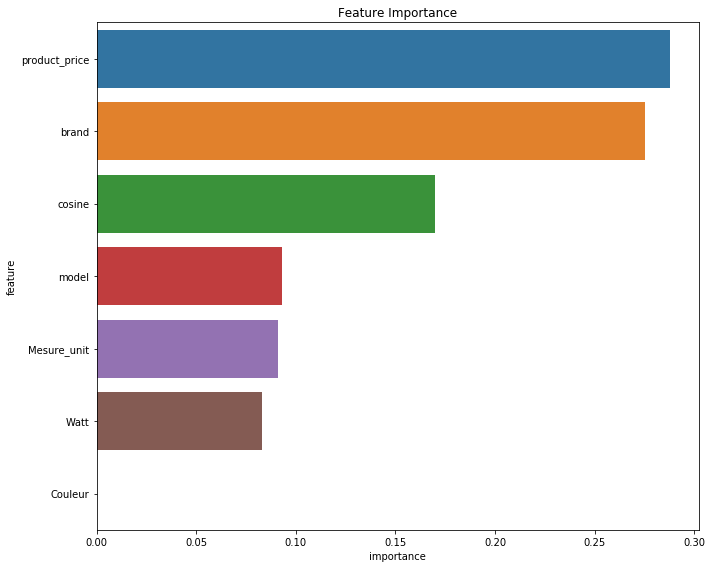

In [43]:
# Calcul des Features Importances
dict_feature_importance = {'feature': list_features+["cosine"], 'importance': clf.feature_importances_}
feature_importances = pd.DataFrame(data=dict_feature_importance).sort_values('importance', ascending=False)


plt.figure(figsize=(10,8))
sns.barplot(x="importance",
            y="feature",
            orient='h',
            data=feature_importances.sort_values(by="importance",
                                                 ascending=False))
plt.title('Feature Importance')
plt.tight_layout()